In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/datapeople.zip

Archive:  /content/drive/MyDrive/datapeople.zip
   creating: datapeople/
   creating: datapeople/Test/
   creating: datapeople/Test/Annotations/
  inflating: datapeople/Test/Annotations/crop001501.xml  
  inflating: datapeople/Test/Annotations/crop001504.xml  
  inflating: datapeople/Test/Annotations/crop001511.xml  
  inflating: datapeople/Test/Annotations/crop001512.xml  
  inflating: datapeople/Test/Annotations/crop001514.xml  
  inflating: datapeople/Test/Annotations/crop001520.xml  
  inflating: datapeople/Test/Annotations/crop001521.xml  
  inflating: datapeople/Test/Annotations/crop001522.xml  
  inflating: datapeople/Test/Annotations/crop001531.xml  
  inflating: datapeople/Test/Annotations/crop001533.xml  
  inflating: datapeople/Test/Annotations/crop001544.xml  
  inflating: datapeople/Test/Annotations/crop001545.xml  
  inflating: datapeople/Test/Annotations/crop001546.xml  
  inflating: datapeople/Test/Annotations/crop001549.xml  
  inflating: datapeople/Test/Annotations/cr

In [3]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

In [4]:
class VOC_Dataset(Dataset):
    def __init__(self, ann_dir, img_dir, transforms=None):
        self.ann_dir = ann_dir
        self.img_dir = img_dir
        self.transforms = transforms
        self.ann_files = sorted([f for f in os.listdir(ann_dir) if f.endswith('.xml')])

    def __getitem__(self, idx):
        ann_path = os.path.join(self.ann_dir, self.ann_files[idx])
        tree = ET.parse(ann_path)
        root = tree.getroot()

        filename = root.find('filename').text
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            if name.lower() != 'person':
                continue
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # label 1: person

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ann_files)

In [5]:
transform = T.ToTensor()

dataset = VOC_Dataset(
    ann_dir="datapeople/Train/Annotations",
    img_dir="datapeople/Train/JPEGImages",
    transforms=transform
)

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

print(f"Dataset have {len(dataset)} pictures.")

Dataset have 614 pictures.


In [6]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

def get_model(num_classes):
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model(num_classes=2)  # background + person
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f}")
    print(device)
torch.save(model.state_dict(), "/content/drive/MyDrive/fasterr_cnn_people.pth")
print("Model saved to /content/drive/MyDrive/fasterr_cnn_people.pth")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 170MB/s]


[Epoch 1] Loss: 48.6066
cuda
[Epoch 2] Loss: 33.5093
cuda
[Epoch 3] Loss: 27.6583
cuda
[Epoch 4] Loss: 23.1483
cuda
[Epoch 5] Loss: 20.4514
cuda
Model saved to /content/drive/MyDrive/fasterr_cnn_people.pth


In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_model(num_classes=2)  # như lúc train
model.load_state_dict(torch.load("/content/drive/MyDrive/fasterr_cnn_people.pth", map_location=device))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
from PIL import Image
import torchvision.transforms as T
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_path = "datapeople/Test/JPEGImages/crop_000006.png"  # Đã bỏ dấu cách và sửa đường dẫn
image = Image.open(img_path).convert("RGB")

transform = T.Compose([T.ToTensor()])
img_tensor = transform(image).to(device)

In [10]:
with torch.no_grad():
    prediction = model([img_tensor])  # đầu vào là list ảnh
pred = prediction[0]
boxes = pred['boxes']          # Tensor Nx4, tọa độ bbox
labels = pred['labels']        # Tensor N
scores = pred['scores']        # Tensor N

In [11]:
threshold = 0.5
keep = scores >= threshold

boxes = boxes[keep].cpu().numpy()
labels = labels[keep].cpu().numpy()
scores = scores[keep].cpu().numpy()

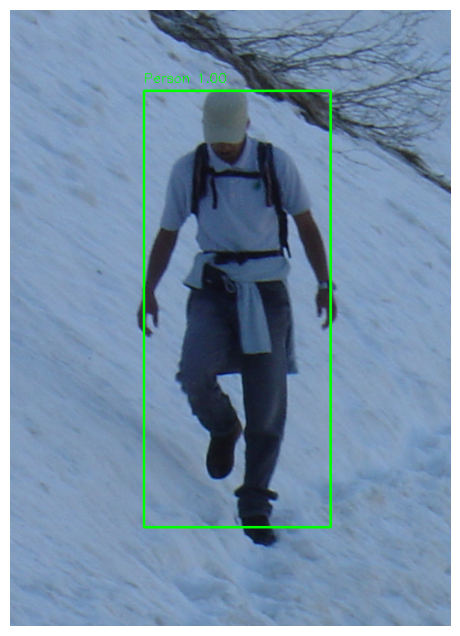

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_cv = np.array(image)[:, :, ::-1].copy()  # PIL RGB → BGR OpenCV

for box, score in zip(boxes, scores):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img_cv, f"Person {score:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [13]:
import torchvision
import torchvision.transforms as T
import torch
import cv2
from tqdm import tqdm
import numpy as np

# Hàm khởi tạo mô hình Faster R-CNN với 2 lớp: background + person
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# Load mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/fasterr_cnn_people.pth", map_location=device))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
transform = T.Compose([T.ToTensor()])

video_path = "/content/drive/MyDrive/Badminton_In.mp4"
output_video_path = "/content/drive/MyDrive/Output_video.mp4"

cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

for _ in tqdm(range(frame_count), desc="Processing frames"):
    ret, frame = cap.read()
    if not ret:
        break

    # Tiền xử lý
    img_tensor = transform(frame).to(device)

    with torch.no_grad():
        prediction = model([img_tensor])[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # Chọn các box có độ tin cậy > 0.5
    filtered = [(box, score) for box, score in zip(boxes, scores) if score > 0.5]

    # Lấy 2 box lớn nhất
    if len(filtered) > 0:
        filtered = sorted(filtered, key=lambda x: (x[0][2]-x[0][0]) * (x[0][3]-x[0][1]), reverse=True)[:2]
        for box, score in filtered:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    out.write(frame)

cap.release()
out.release()
print(f"✅ Video đã lưu tại: {output_video_path}")

Processing frames: 100%|██████████| 18020/18020 [42:57<00:00,  6.99it/s]

✅ Video đã lưu tại: /content/drive/MyDrive/Output_video.mp4


In [16]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
grpcio

In [20]:
!pip uninstall -y numpy

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5


In [21]:
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.

In [1]:
!pip install mediapipe

In [2]:
import cv2
import mediapipe as mp
import pandas as pd

# MediaPipe khởi tạo
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Đường dẫn file
input_path = "/content/drive/MyDrive/Output_video.mp4"  # Thay bằng thư mục bạn đã upload
output_video_path = "/content/drive/MyDrive/landmarks_video.mp4"
output_csv_path = "/content/drive/MyDrive/foot_positions_detect.csv"

# Mở video
cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Ghi video đầu ra
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Data cho CSV
all_data = []
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(img_rgb)

    landmarks_list = []

    if results.pose_landmarks:
        # Trong video có sẵn 2 người, giả định MediaPipe detect được cả 2.

        # Giả định MediaPipe chỉ trả về 1 người => bạn cần tự thêm bước detect 2 người nếu cần thiết
        # Ở đây tạm coi bạn đã có logic để có danh sách 2 người trong landmarks_list
        # Tạm thời chỉ xử lý 1 người: bạn có thể mở rộng sau
        landmarks = results.pose_landmarks.landmark

        # Lấy gót chân trái/phải
        left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
        right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]

        l_heel = (int(left_heel.x * width), int(left_heel.y * height))
        r_heel = (int(right_heel.x * width), int(right_heel.y * height))

        landmarks_list.append({'left_heel': l_heel, 'right_heel': r_heel})

    # Gán player1, player2 theo vị trí trái/phải
    def get_avg_x(lm):  # trung bình x để biết bên trái hay phải
        return (lm['left_heel'][0] + lm['right_heel'][0]) / 2

    sorted_players = sorted(landmarks_list, key=get_avg_x)

    for i, player in enumerate(sorted_players):
        player_id = f'player{i+1}'

        lx, ly = player['left_heel']
        rx, ry = player['right_heel']

        # Vẽ lên khung hình
        cv2.circle(frame, (lx, ly), 8, (255, 0, 0), -1)
        cv2.circle(frame, (rx, ry), 8, (0, 255, 0), -1)
        cv2.putText(frame, player_id, (int((lx+rx)/2), int((ly+ry)/2)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        all_data.append({
            'frame': frame_idx,
            'player': player_id,
            'left_heel_x': lx,
            'left_heel_y': ly,
            'right_heel_x': rx,
            'right_heel_y': ry
        })

    out.write(frame)
    frame_idx += 1

# Lưu CSV
df = pd.DataFrame(all_data)
df.to_csv(output_csv_path, index=False)

# Đóng video
cap.release()
out.release()
pose.close()

In [3]:
import cv2 as cv
import numpy as np

cap = cv.VideoCapture("/content/drive/MyDrive/Badminton_In.mp4")
cap.set(cv.CAP_PROP_POS_FRAMES, 1000)
ret, frame = cap.read()
cap.release()

img = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

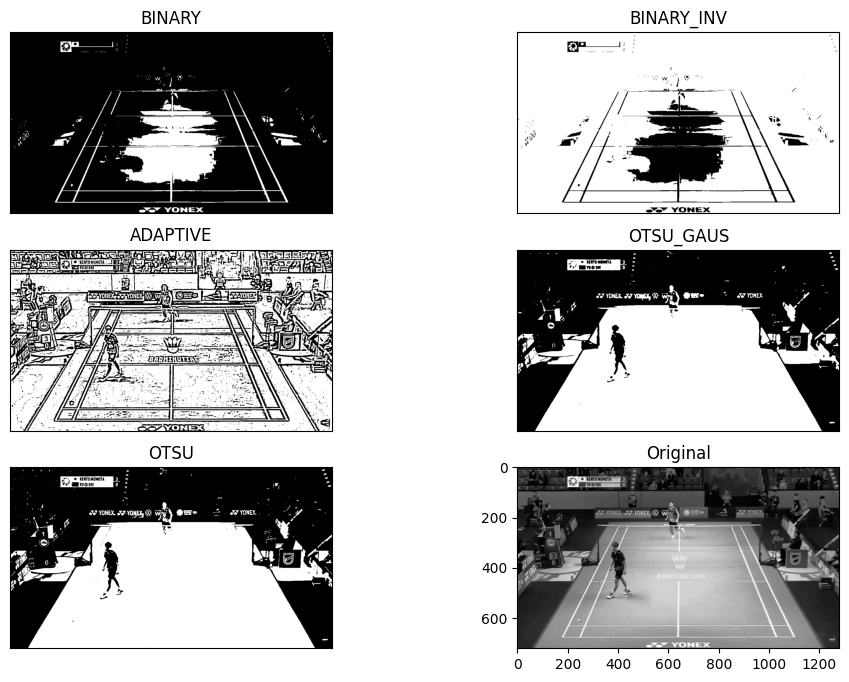

In [4]:
# Testing different Image Binarizations

from matplotlib import pyplot as plt

ret,th1 = cv.threshold(img,190,255,cv.THRESH_BINARY)
ret,th2 = cv.threshold(img,190,255,cv.THRESH_BINARY_INV)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

blur = cv.GaussianBlur(img,(5,5),0)
ret,th4 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

ret,th5 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

images = [th1,th2,th3,th4, th5]
titles = ['BINARY', 'BINARY_INV', 'ADAPTIVE', 'OTSU_GAUS', 'OTSU']


plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.subplot(3,2,6)
plt.imshow(img, 'gray')
plt.title('Original')
plt.show()

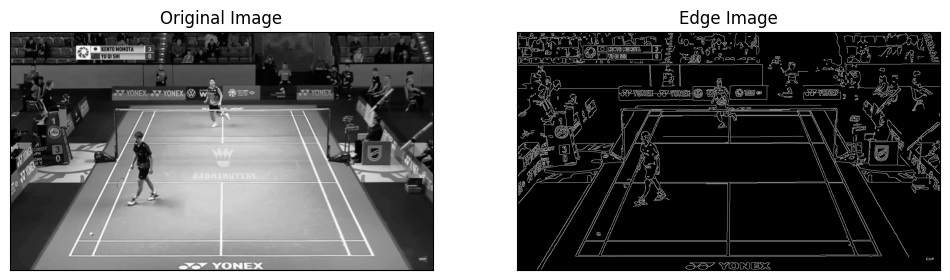

In [5]:
import numpy as np

# Visualizing edges

v = np.median(img)
sigma = 0.33

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv.Canny(img, lower, upper, apertureSize=3)

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

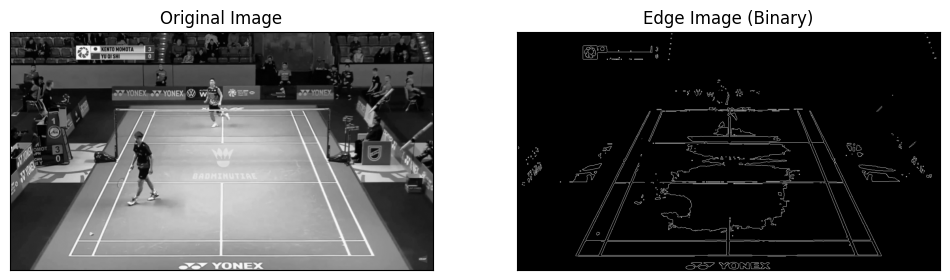

In [6]:
# Visualizing edges for binarized image

v = np.median(img)
sigma = 0.33

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv.Canny(th1, lower, upper, apertureSize=3)

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image (Binary)'), plt.xticks([]), plt.yticks([])
plt.show()

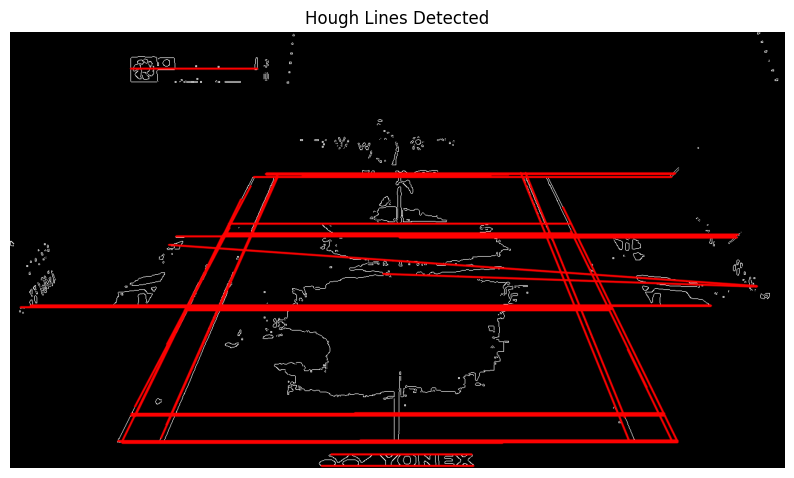

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
# Giả sử bạn đã có ảnh edges từ Canny trước đó
# edges = cv.Canny(...)

# Chuyển ảnh edges sang BGR để vẽ đường màu lên
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

# Probabilistic Hough Transform
linesP = cv.HoughLinesP(edges, 1, np.pi / 90, 90, None, 10, 250)

if linesP is not None:
    for i in range(len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2, cv.LINE_AA)

# Hiển thị ảnh kết quả trong notebook (KHÔNG lưu, KHÔNG dùng imshow)
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(cdstP, cv.COLOR_BGR2RGB))  # Chuyển từ BGR sang RGB cho đúng màu
plt.title('Hough Lines Detected')
plt.axis('off')
plt.show()

In [8]:
def segment_lines(lines, deltaX, deltaY):
    h_lines = []
    v_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(y2-y1) < deltaY: # y-values are near; line is horizontal
                h_lines.append(line)
            elif abs(x2-x1) < deltaX: # x-values are near; line is vertical
                v_lines.append(line)
    return h_lines, v_lines
h_lines, v_lines = segment_lines(linesP, 500, 0.5)
print('Total number of lines: ', linesP.shape[0])
print('Number of horizontal lines: ', len(h_lines))
print('Number of vertical lines: ', len(v_lines))

Total number of lines:  43
Number of horizontal lines:  30
Number of vertical lines:  11


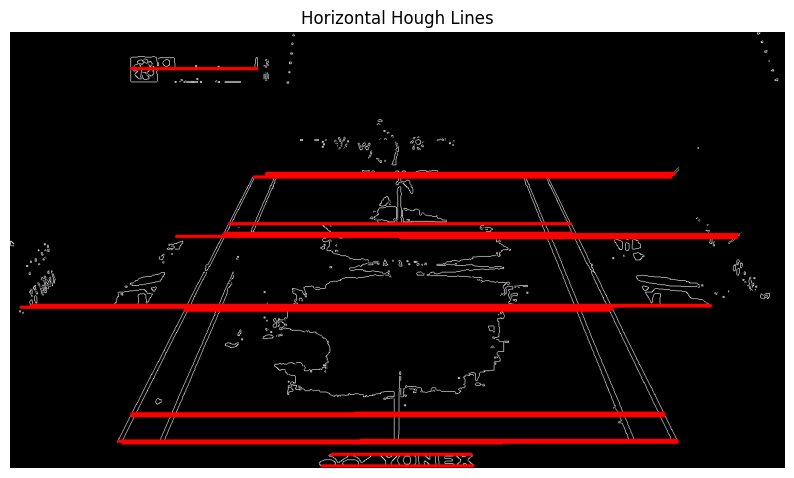

In [9]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

# Vẽ các đường ngang
for i in range(len(h_lines)):
    l = h_lines[i][0]
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv.LINE_AA)

# Hiển thị bằng matplotlib (đúng màu)
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(cdstP, cv.COLOR_BGR2RGB))  # chuyển sang RGB để hiển thị
plt.title('Horizontal Hough Lines')
plt.axis('off')
plt.show()

In [26]:
import math

def getCourtLines(hsegments, vsegments, debug=True, tolerance=40):
    h_result = []
    v_result = []

    for segment in hsegments:
        for x1, y1, x2, y2 in segment:
            dist = math.dist([x1, y1], [x2, y2])
            if debug:
                print(f"[HORIZONTAL] Dist: {dist:.2f}")
            # Lọc theo khoảng dài tương đối (ví dụ 600 hoặc 1100 với ± tolerance)
            if (560 - tolerance < dist < 560 + tolerance) or (1150 - tolerance < dist < 1150 + tolerance):
                h_result.append(segment)

    for segment in vsegments:
        for x1, y1, x2, y2 in segment:
            dist = math.dist([x1, y1], [x2, y2])
            if debug:
                print(f"[VERTICAL] Dist: {dist:.2f}")
            if (480 - tolerance < dist < 480 + tolerance) or (680 - tolerance < dist < 680 + tolerance):
                v_result.append(segment)

    return h_result, v_result

In [27]:
filtered_h_lines, filtered_v_lines = getCourtLines(
    filterLines(h_lines, 300, 1300),
    filterLines(v_lines, 300, 900),
    debug=True,
    tolerance=50  # có thể giảm nếu phát hiện dư
)

print('✅ Filtered Horizontal Lines:', len(filtered_h_lines))
print('✅ Filtered Vertical Lines:', len(filtered_v_lines))

Length: 880.0
200 630 	 1080 630 	 880.0
------------------------------
Length: 882.0
199 633 	 1081 633 	 882.0
------------------------------
Length: 525.0
577 677 	 1102 677 	 525.0
------------------------------
Length: 669.0
178 675 	 847 675 	 669.0
------------------------------
Length: 628.0
185 678 	 813 678 	 628.0
------------------------------
Length: 924.0
274 337 	 1198 337 	 924.0
------------------------------
Length: 511.0
569 629 	 1080 629 	 511.0
------------------------------
Length: 524.0
578 674 	 1102 674 	 524.0
------------------------------
Length: 706.0
289 457 	 995 457 	 706.0
------------------------------
Length: 976.0
17 454 	 993 454 	 976.0
------------------------------
Length: 1123.0
34 452 	 1157 452 	 1123.0
------------------------------
Length: 951.0
35 453 	 986 453 	 951.0
------------------------------
Length: 701.0
288 459 	 989 459 	 701.0
------------------------------
Length: 250.0
------------------------------
Length: 565.0
361 316 	 92

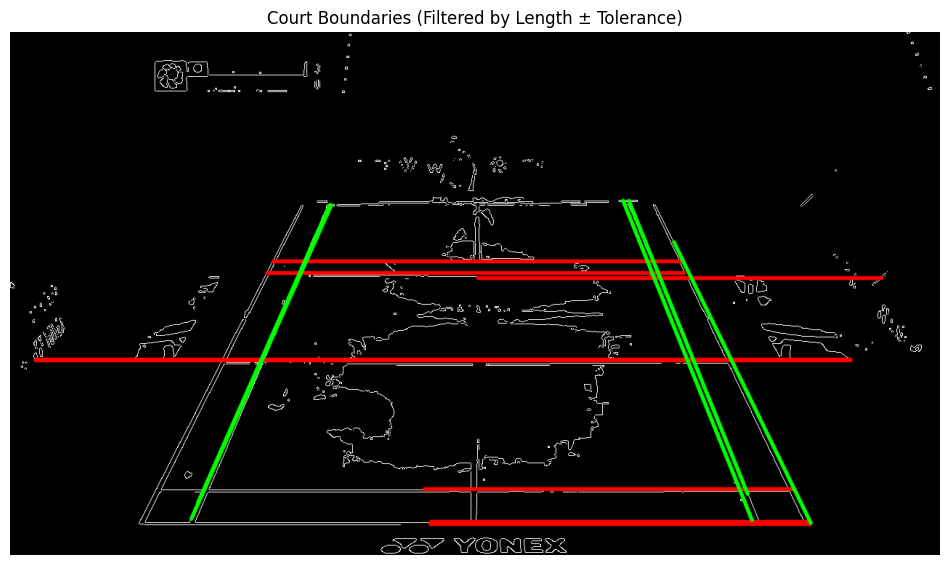

In [28]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

for seg in filtered_h_lines:
    x1, y1, x2, y2 = seg[0]
    cv.line(cdstP, (x1, y1), (x2, y2), (255, 0, 0), 3, cv.LINE_AA)  # xanh dương

for seg in filtered_v_lines:
    x1, y1, x2, y2 = seg[0]
    cv.line(cdstP, (x1, y1), (x2, y2), (0, 255, 0), 3, cv.LINE_AA)  # xanh lá

plt.figure(figsize=(12, 8))
plt.imshow(cdstP)
plt.title('Court Boundaries (Filtered by Length ± Tolerance)')
plt.axis('off')
plt.show()

In [29]:
print("Số điểm giao nhau:", len(Px))
print("Px:", Px[:5])
print("Py:", Py[:5])

Số điểm giao nhau: 4
Px: [120 150 300 320]
Py: [100 110 200 220]


In [34]:
def select_extreme_lines(lines, axis='x'):
    """
    Chọn 2 line có giá trị x hoặc y nhỏ nhất và lớn nhất.
    """
    if axis == 'x':
        values = [min(line[0][0], line[0][2]) for line in lines]
    else:
        values = [min(line[0][1], line[0][3]) for line in lines]

    if len(values) < 2:
        return lines  # Không đủ

    idx_min = np.argmin(values)
    idx_max = np.argmax(values)

    return [lines[idx_min], lines[idx_max]]

In [35]:
main_h_lines = select_extreme_lines(filtered_h_lines, axis='y')
main_v_lines = select_extreme_lines(filtered_v_lines, axis='x')
Px, Py = findIntersections(main_h_lines, main_v_lines)

In [36]:
def findIntersections(h_lines, v_lines):
    Px, Py = [], []
    for h in h_lines:
        x1, y1, x2, y2 = h[0]
        for v in v_lines:
            x3, y3, x4, y4 = v[0]
            denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
            if denom == 0:
                continue  # song song
            px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
            py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
            Px.append(px)
            Py.append(py)
    return Px, Py

In [37]:
Px, Py = findIntersections(filtered_h_lines, filtered_v_lines)

In [42]:
from sklearn.cluster import KMeans

points = np.float32(np.column_stack((Px, Py)))
kmeans = KMeans(n_clusters=4, n_init='auto').fit(points)
centers = kmeans.cluster_centers_

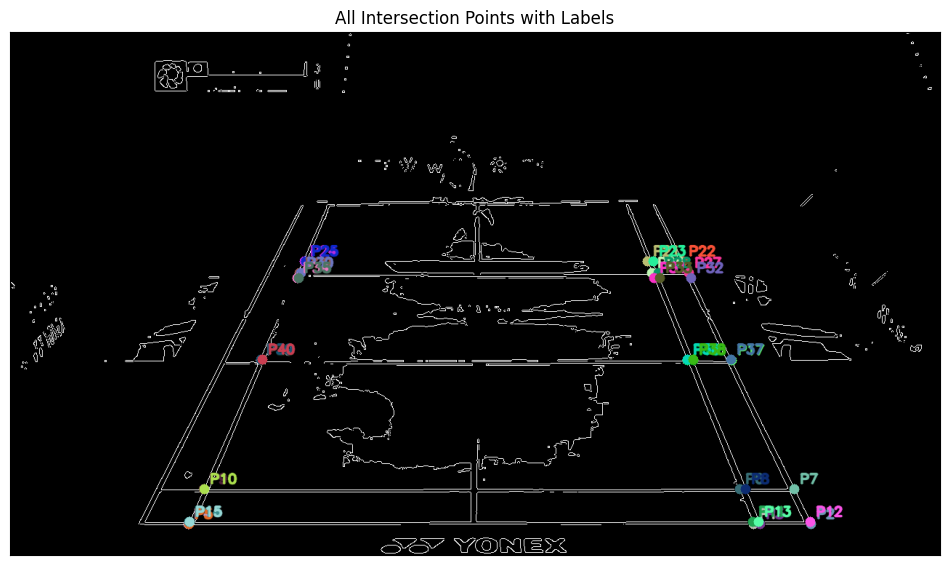

In [43]:
intersectsimg = edges.copy()
intersectsimg = cv.cvtColor(intersectsimg, cv.COLOR_GRAY2BGR)

for idx, (cx, cy) in enumerate(zip(Px, Py)):
    cx = int(round(cx))
    cy = int(round(cy))

    color = np.random.randint(0, 255, 3).tolist()

    # Vẽ điểm
    cv.circle(intersectsimg, (cx, cy), radius=7, color=color, thickness=-1)

    # Gắn nhãn "P1", "P2",...
    cv.putText(intersectsimg, f'P{idx+1}', (cx + 8, cy - 8),
               cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv.LINE_AA)

# Hiển thị ảnh với điểm giao
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(intersectsimg, cv.COLOR_BGR2RGB))
plt.title('All Intersection Points with Labels')
plt.xticks([]), plt.yticks([])
plt.show()


In [48]:
def select_extreme_lines(lines, axis='x'):
    """
    Chọn 2 đường biên dựa trên giá trị min/max theo trục x hoặc y.
    """
    if axis == 'x':
        values = [min(line[0][0], line[0][2]) for line in lines]
    else:
        values = [min(line[0][1], line[0][3]) for line in lines]

    if len(values) < 2:
        return lines  # nếu không đủ line

    idx_min = np.argmin(values)
    idx_max = np.argmax(values)

    return [lines[idx_min], lines[idx_max]]

In [49]:
def findIntersections(h_lines, v_lines):
    Px, Py = [], []
    for h in h_lines:
        x1, y1, x2, y2 = h[0]
        for v in v_lines:
            x3, y3, x4, y4 = v[0]
            denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
            if denom == 0:
                continue  # song song
            px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
            py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
            Px.append(px)
            Py.append(py)
    return Px, Py

In [50]:
# Chọn 2 đường ngang trên & dưới
main_h_lines = select_extreme_lines(filtered_h_lines, axis='y')

# Chọn 2 đường dọc trái & phải
main_v_lines = select_extreme_lines(filtered_v_lines, axis='x')

# Tính giao điểm 4 góc
Px, Py = findIntersections(main_h_lines, main_v_lines)

print("4 góc sân:")
for i in range(len(Px)):
    print(f"P{i+1}: ({Px[i]:.1f}, {Py[i]:.1f})")

4 góc sân:
P1: (407.2, 316.0)
P2: (926.2, 316.0)
P3: (245.9, 677.0)
P4: (1102.5, 677.0)


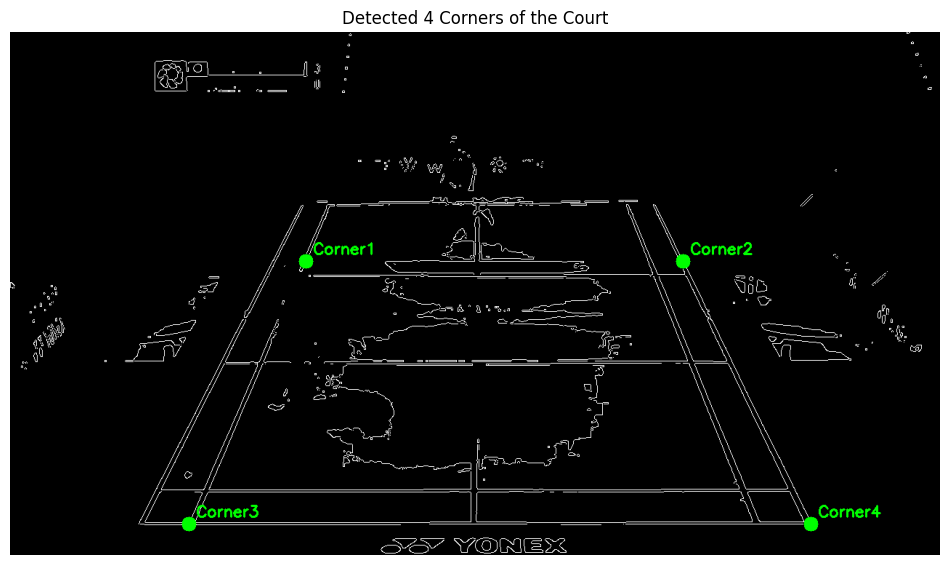

In [51]:
intersectsimg = edges.copy()
intersectsimg = cv.cvtColor(intersectsimg, cv.COLOR_GRAY2BGR)

for idx, (cx, cy) in enumerate(zip(Px, Py)):
    cx, cy = int(round(cx)), int(round(cy))
    color = (0, 255, 0)  # Màu xanh lá
    cv.circle(intersectsimg, (cx, cy), 10, color, -1)
    cv.putText(intersectsimg, f'Corner{idx+1}', (cx+10, cy-10),
               cv.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(intersectsimg, cv.COLOR_BGR2RGB))
plt.title('Detected 4 Corners of the Court')
plt.axis('off')
plt.show()

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Load dữ liệu CSV từ bước trước
df = pd.read_csv("/content/drive/MyDrive/foot_positions_detect.csv")
# Các điểm homography: image (pixel) -> court (cm)
image_pts = np.array([
    [407.2, 316.0],  # Top-left
    [926.2, 316.0],  # Top-right
    [245.9, 677.0],  # Bottom-left
    [1102.5, 677.0], # Bottom-right
], dtype=np.float32)
court_pts = np.array([[0, 0], [610, 0], [0, 1340], [610, 1340]], dtype=np.float32)

H, _ = cv2.findHomography(image_pts, court_pts)

def apply_homography(x, y):
    pts = np.array([[x, y]], dtype='float32')
    pts = np.array([pts])
    dst = cv2.perspectiveTransform(pts, H)
    return dst[0][0]

# Tính vị trí trung bình gót chân → chuyển đổi
df['foot_x'] = (df['left_heel_x'] + df['right_heel_x']) / 2
df['foot_y'] = (df['left_heel_y'] + df['right_heel_y']) / 2

court_coords = df[['foot_x', 'foot_y']].apply(lambda row: apply_homography(row['foot_x'], row['foot_y']), axis=1)
df[['court_x', 'court_y']] = pd.DataFrame(court_coords.tolist(), index=df.index)

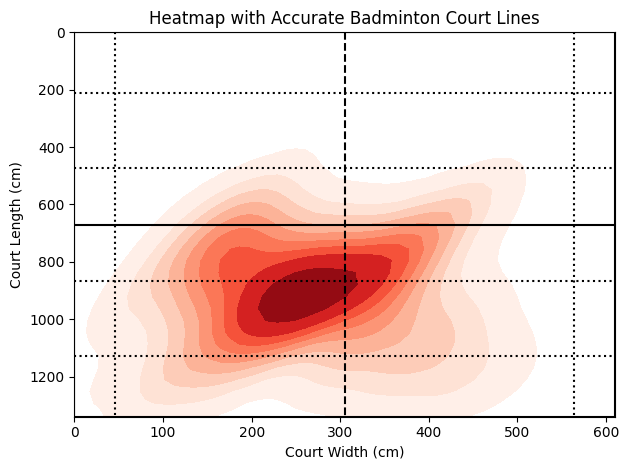

In [56]:

# Vẽ heatmap
sns.kdeplot(
    data=df, x='court_x', y='court_y',
    fill=True, cmap='Reds', bw_adjust=0.6, thresh=0.1
)


# Vẽ các đường sân cầu lông
court_w = 610
court_l = 1340

# Đường bao sân (đánh đôi)
plt.plot([0, court_w], [0, 0], 'k')  # biên ngang dưới
plt.plot([0, court_w], [court_l, court_l], 'k')  # biên ngang trên
plt.plot([0, 0], [0, court_l], 'k')  # biên dọc trái
plt.plot([court_w, court_w], [0, court_l], 'k')  # biên dọc phải

# Vạch giữa sân (từ lưới)
center_x = court_w / 2
plt.plot([center_x, center_x], [0, court_l], 'k', linestyle='--')

# Lưới ở giữa sân
net_y = court_l / 2
plt.plot([0, court_w], [net_y, net_y], 'k')

# Đường phát cầu ngắn (cách lưới 198 cm mỗi bên)
plt.plot([0, court_w], [net_y - 198, net_y - 198], 'k', linestyle=':')
plt.plot([0, court_w], [net_y + 198, net_y + 198], 'k', linestyle=':')

# Đường phát cầu dài cho đôi (cách biên ngang 210 cm mỗi bên)
plt.plot([0, court_w], [court_l - 210, court_l - 210], 'k', linestyle=':')
plt.plot([0, court_w], [210, 210], 'k', linestyle=':')

# Biên đơn (chỉ cần nếu bạn phân biệt đánh đơn và đôi)
single_sideline_left = (court_w - 518) / 2
single_sideline_right = court_w - single_sideline_left
plt.plot([single_sideline_left, single_sideline_left], [0, court_l], 'k', linestyle=':')
plt.plot([single_sideline_right, single_sideline_right], [0, court_l], 'k', linestyle=':')

# Hiển thị
plt.title('Heatmap with Accurate Badminton Court Lines')
plt.xlim(0, court_w)
plt.ylim(0, court_l)
plt.gca().invert_yaxis()
plt.xlabel('Court Width (cm)')
plt.ylabel('Court Length (cm)')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/heatmap_player.png", dpi=300)
plt.show()

<ipython-input-57-d4d8b91c4a6f>:6: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[df['player'] == 'player2'], x='court_x', y='court_y',
<ipython-input-57-d4d8b91c4a6f>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


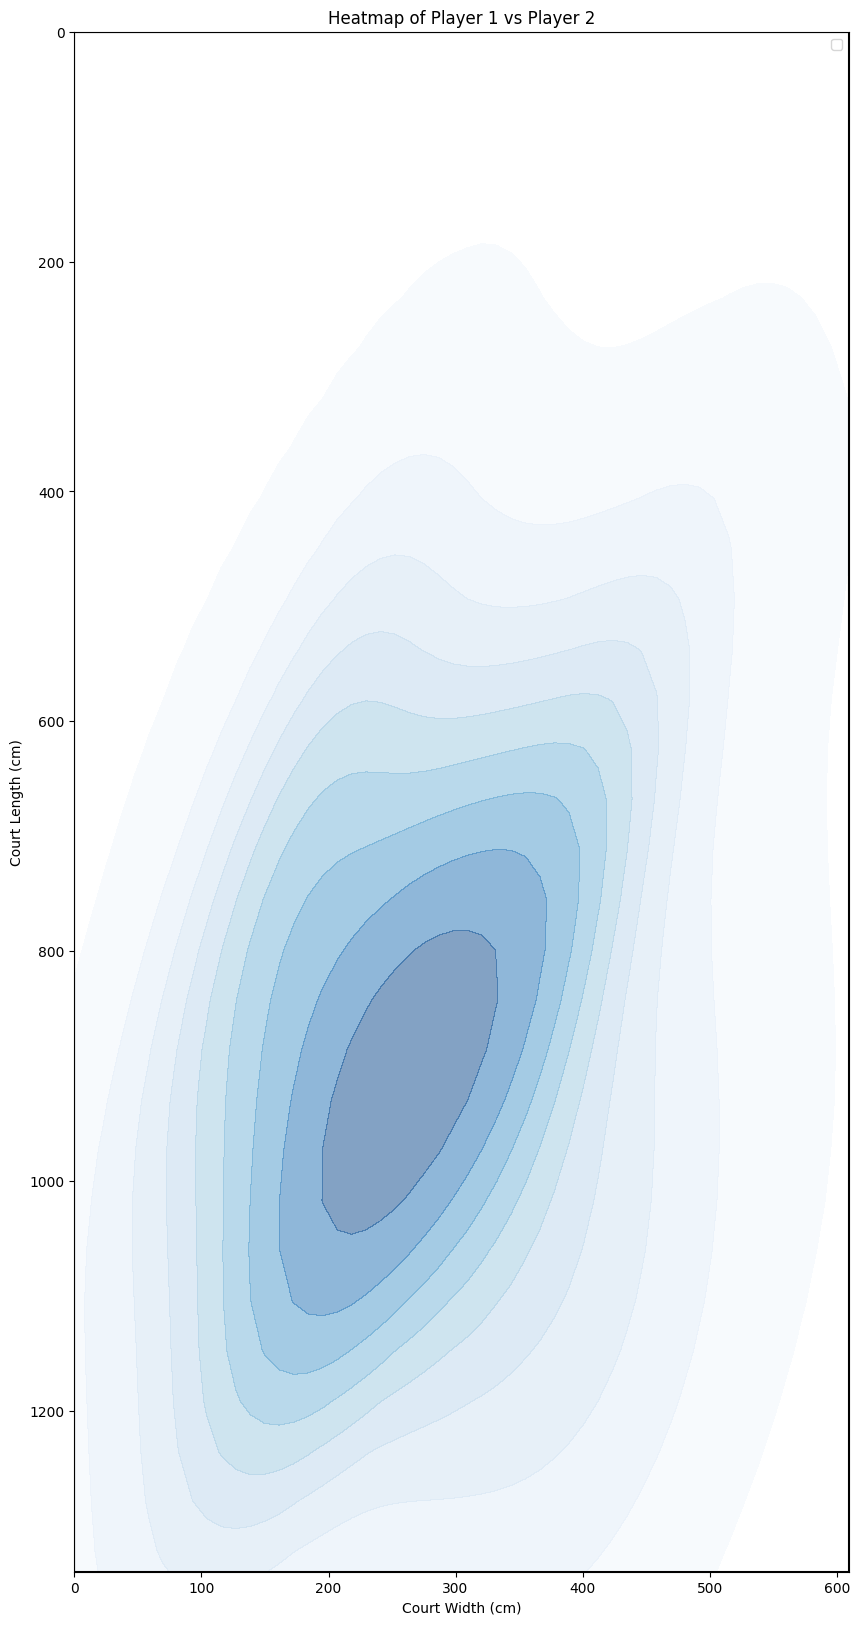

In [57]:
plt.figure(figsize=(10, 20))

sns.kdeplot(data=df[df['player'] == 'player1'], x='court_x', y='court_y',
            fill=True, cmap='Blues', label='Player 1', alpha=0.5)

sns.kdeplot(data=df[df['player'] == 'player2'], x='court_x', y='court_y',
            fill=True, cmap='Oranges', label='Player 2', alpha=0.5)

# Vẽ biên sân như trên
plt.plot([0, court_w], [0, 0], 'k')
plt.plot([0, court_w], [court_l, court_l], 'k')
plt.plot([0, 0], [0, court_l], 'k')
plt.plot([court_w, court_w], [0, court_l], 'k')

plt.title("Heatmap of Player 1 vs Player 2")
plt.xlabel("Court Width (cm)")
plt.ylabel("Court Length (cm)")
plt.xlim(0, court_w)
plt.ylim(0, court_l)
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("/content/drive/MyDrive/heatmap_player1vsplayer2.png", dpi=300)
plt.show()